# Data

The hackathon data analysis is a summary of the EDA activities you have completed.  This should include data cleaning, pre-processing, exploratory analysis, and insights you have generated from your data. Each group will submit and demonstrate one notebook (in ipynb and pdf) that comprises the following sections:
### 1.Domain: Explain the domain/subdomain of this project (use images)
### 2.Data: Go over 1 row of the data explaining relevant columns
### 3.Insights: Show intuitive and non-intuitive insights generated from your EDA
### 4.Objective: Sample input and output
### 5.Training: Overview of models tried and evaluation metrics
### 6.Scoring: Sample scoring input and output
### 7.Takeaways: Summarize the model and how it may be improved
___

# Domain

## Cloud Computing

**Cloud Computing (NIST)**:  a model for enabling on-demand network access to a shared 
pool of computing resources (e.g., networks, servers, storage, applications, 
and services) that can be rapidly provisioned and released with minimal management 
effort or service provider interaction.  

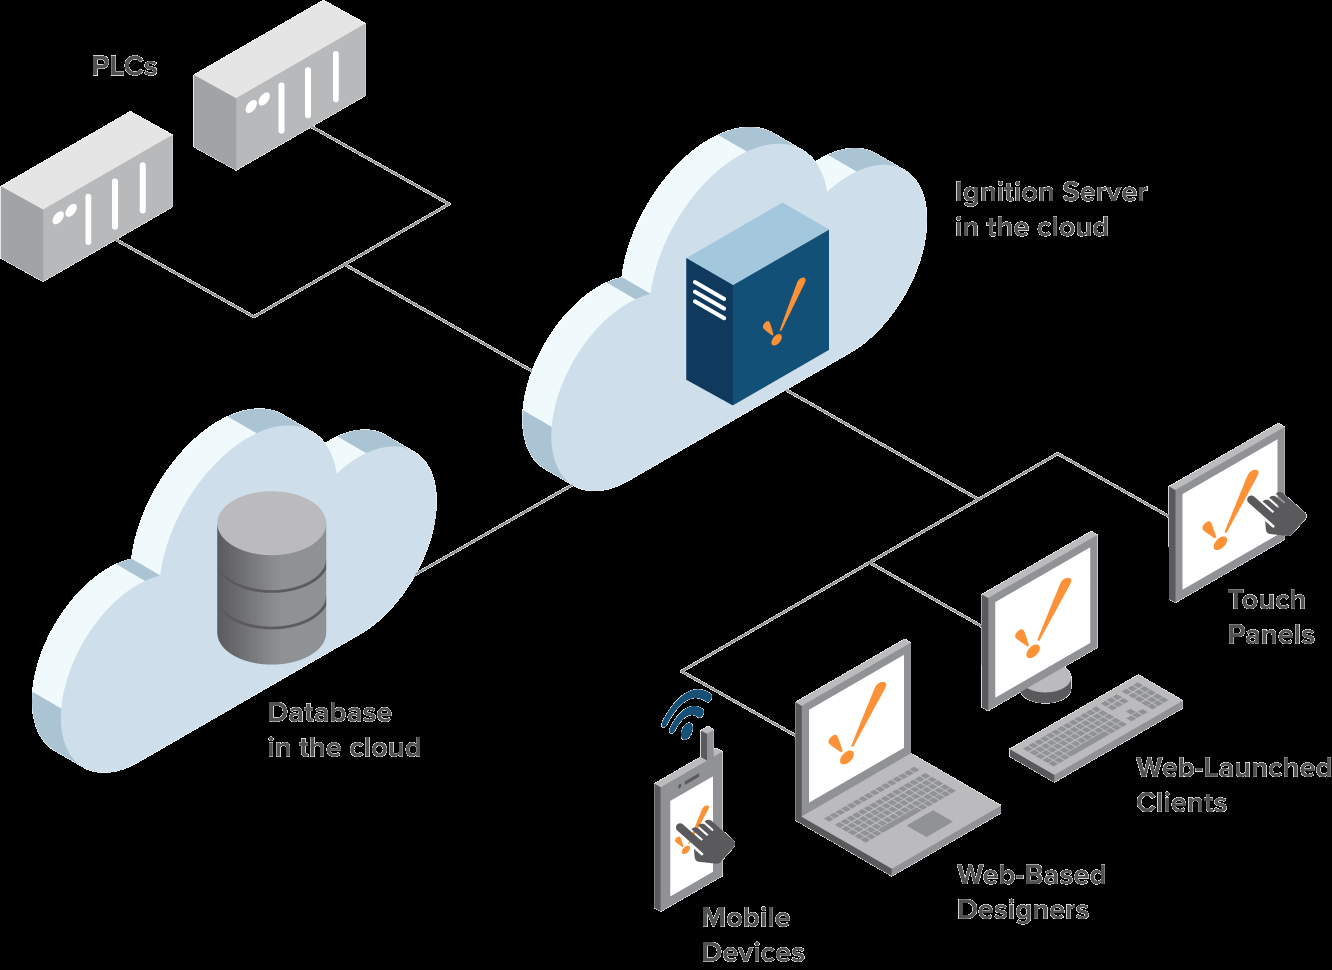

**5 Key Characteristics of Cloud Computing**

> 1. Broad Network Access
> 2. Measured Service
> 3. On Demand Self Service
> 4. Shared Resource Pooling
> 5. Rapid Elasticity

**3 Service Models**

> 1. **Software as a Service (SaaS)**: Provider’s applications running on a cloud infrastructure

> 2. **Platform as a Service (PaaS)**: Consumer-created or acquired applications created using tools supported by the provider

> 3. **Infrastructure as a Service (IaaS)**: Consumer is able to deploy and run arbitrary software on storage, networks, etc.

## Leading Cloud Service Providers

1. **Amazon Web Services (AWS)**  
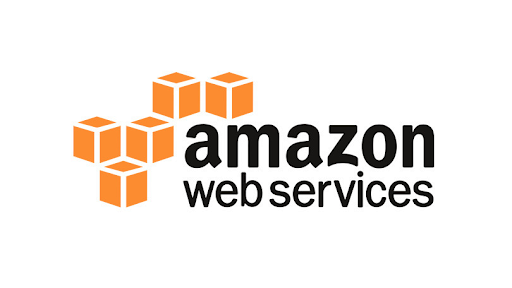

2. **Microsoft Azure**    
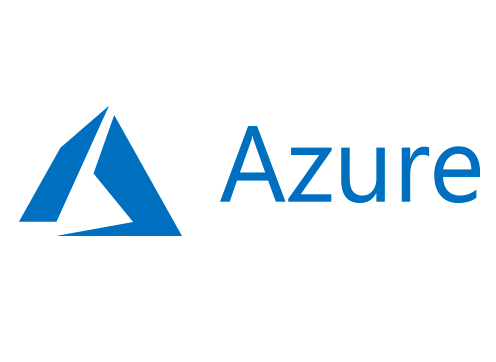

3. Google Cloud Platform  
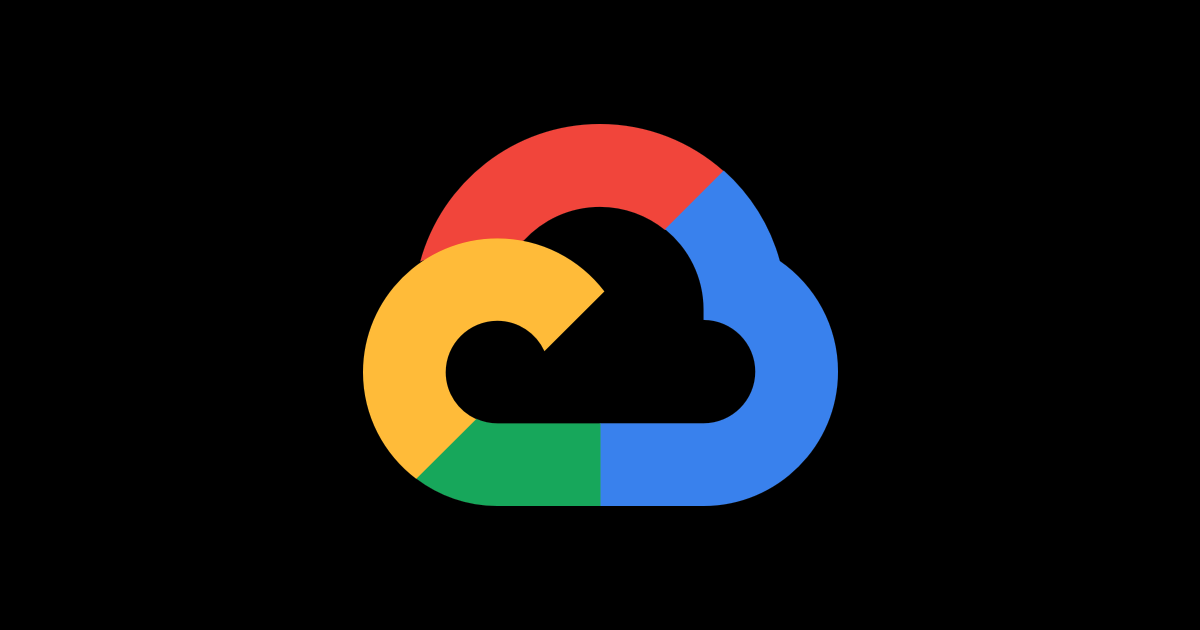

**Cloud Migration**: the process of moving a company’s digital assets, services, databases, IT resources, and applications either partially, or wholly, into the cloud. 

## Cloud Management

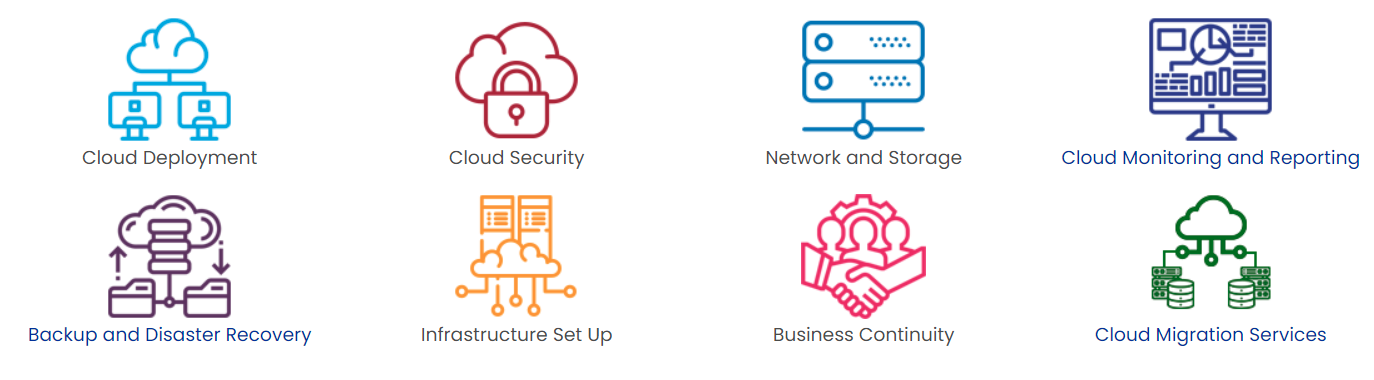

**MultiCloudX**: Austin based start-up that functions as a third-party cloud manager to manage cloud storage, operations, and costs

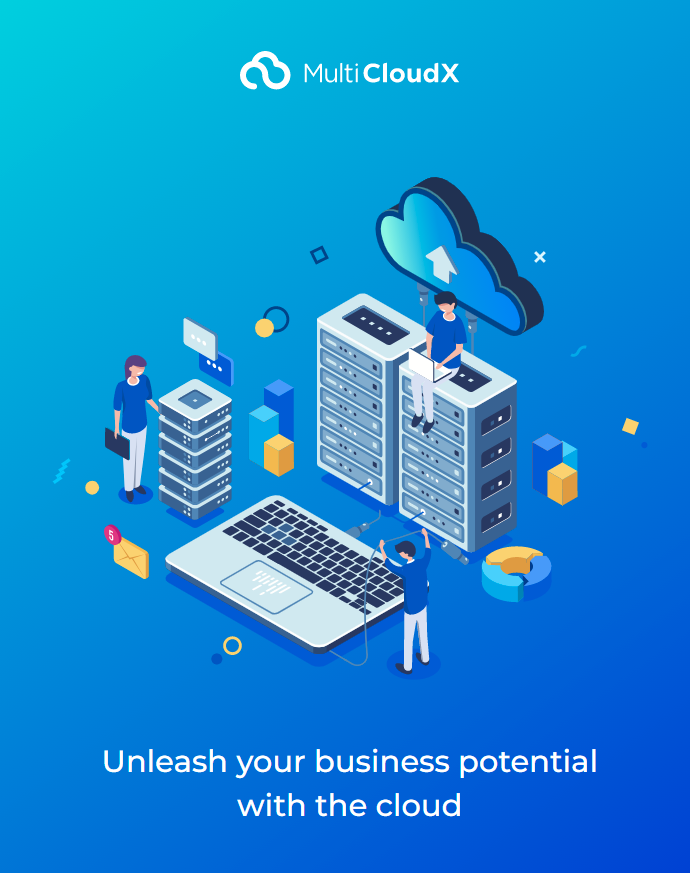

# Data
_____

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Expected Objective/Modelling
_____

Time series modelling is not well modelled by traditional linear regression or decision trees due to the stochastic nature of the data. Because of this, we have to use modelling that has so-far not been used in this class. The current popular models for time series data are ARIMA (autoregressive integrated moving average) and LTSM Neural Networks (long short-term memory). We would like to put in a the features created in the last section and have an output of the total cost for the next month.

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [26]:
# First start the creation of our final dataframe, starting with total monthly cost
def process_dataframe(df, fillna=True):
    """
    Processes a dataFrame from what's initially given to a usable form for our model.
    """
    dfProcessed = df.groupby("invoice_month").agg({"total_cost": "sum"})
    products = dfTotal["product_name"].unique()
    # Loops through all of the unique product names
    for product in products:
        # Grabs the monthly total cost and usage for each product
        df_product_monthly = df.loc[df["product_name"] == product].groupby("invoice_month").agg({"total_cost": "sum", "usage_amount": "sum"}).rename(columns={"total_cost" : product + " cost", "usage_amount": product + " usage"})
        #Concatenates that onto the total dataframe we have
        dfProcessed = pd.concat([dfProcessed, df_product_monthly], axis=1)
        dfProcessed.columns = dfProcessed.columns.str.replace(' ', '_')
        
    if fillna==True:    
        dfProcessed = dfProcessed.fillna(0)
    
    
    return dfProcessed

In [27]:
def selectFeatures(df):
    coli = ["total_cost", "Amazon_Elastic_Compute_Cloud_cost", "Amazon_Relational_Database_Service_cost", "Amazon_Simple_Storage_Service_cost", "Amazon_DocumentDB_(with_MongoDB_compatibility)_cost" , "Amazon_Elastic_File_System_cost"]
    dfVoi = df[coli]
    dfVoi.columns = dfVoi.columns.str.replace('Amazon_', '')
    dfVoi.columns = dfVoi.columns.str.replace('_(with_MongoDB_compatibility)_', '_')
    
    return dfVoi

In [28]:
def irvTrainSplit(X, y, split):
    """
    Split the test and train data for the target variable and features. Modification by Irvin from the previous testTrainSplit created by Upayan.
    """
    
    # Get shape of first dimension of tensor and say what needs to be split to get the last X datapoints to be dropped from the training and into the testing
    splitter = int(X.shape[0]*split)
    test_X = X[splitter:]
    train_X = X[:splitter]
    test_y = y[splitter:]
    train_y = y[:splitter]
    
#     print('X train shape == {}.'.format(train_X.shape))
#     print('Y train shape == {}.'.format(train_y.shape))
#     print('X test shape == {}.'.format(test_X.shape))
#     print('Y test shape == {}.'.format(test_y.shape))
    
    return train_X, test_X, train_y, test_y

In [29]:
def CustomSplit(X, y, locations):
    """
    Splits in a custom spot
    """
    test_X = X[locations]
    train_X = np.delete(X, locations, axis=0)
    test_y = y[locations]
    train_y = np.delete(y, locations, axis=0)
    
#     print('X train shape == {}.'.format(train_X.shape))
#     print('Y train shape == {}.'.format(train_y.shape))
#     print('X test shape == {}.'.format(test_X.shape))
#     print('Y test shape == {}.'.format(test_y.shape))
    
    return train_X, test_X, train_y, test_y

In [30]:
def to_supervised (df_for_training, n_future, n_past):
    trainX = []
    trainY = []

    for i in range(n_past, len(df_for_training) - n_future +1):
        trainX.append(df_for_training[i - n_past:i, 0:df_for_training.shape[1]])
        trainY.append(df_for_training[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    
    return trainX, trainY


In [43]:
class CustomTensorData:
    def __init__(self, df, locations, n_future, n_past, name):
            self.df = process_dataframe(df, fillna=True)
            self.months = self.df.index
            self.ss = StandardScaler()
            dfScaled = self.ss.fit_transform(self.df)
            X, y = to_supervised(dfScaled, n_future, n_past)
            self.train_X, self.test_X, self.train_y, self.test_y =  CustomSplit(X, y, locations)
            self.name = name
            self.split_locations = locations
            self.n_past = n_past

In [34]:
def build_model (trainX, trainY, epoch, bs):
    
    
    model = Sequential()
    model.add(LSTM(16, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(LSTM(8, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))

    model.compile(optimizer='adam', loss='mse') #custom loss function, l2/l1 regularization
    model.summary()
    
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
    mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

    tb = TensorBoard('logs')

    history = model.fit(trainX, trainY, shuffle=True, epochs= epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size= bs)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    
    return model

In [36]:
def custom_evaluate_predictions(model, company):
    """
    Takes final predictions and compares them graphically and statistically against the true values
    """
    
    forecast = model.predict(company.test_X)
    
    forecast_copies = np.repeat(forecast, company.test_X.shape[2], axis=-1)
    forecast = company.ss.inverse_transform(forecast_copies)[:,0]
    
    y_copies = np.repeat(company.test_y, company.test_X.shape[2], axis=-1)
    y = company.ss.inverse_transform(y_copies)[:,0]
    future_time = company.months[[x + company.n_past for x in company.split_locations]]

    
    print(future_time)
    
    plt.title(company.name)
    plt.xticks(rotation=90)
    plt.plot(company.df.total_cost, label="Original")
    plt.scatter(company.df.index, company.df.total_cost, label="Original")
    plt.scatter(future_time, forecast, label="Predictions", color="red")
    plt.legend()
    plt.show();

    print("MSE:", mean_squared_error(forecast, y)) 
    print("MAE: ", mean_absolute_error(forecast, y))
    # print("R^2:", r2_score(forecast, y))
    
    return

## Doubling individual models with custom selection

In [151]:
PYCO_custom = CustomTensorData(dfPYCO, [1, 5, 3], 1, 2, "PYCO")
CCO_custom = CustomTensorData(dfCCO, [1], 1, 2, "CCO")
XCO_custom = CustomTensorData(dfXCO, [1, 5, 3], 1, 2, "XCO")

trainX shape == (13, 2, 95).
trainY shape == (13, 1).
trainX shape == (6, 2, 95).
trainY shape == (6, 1).
trainX shape == (15, 2, 95).
trainY shape == (15, 1).


In [164]:
trainX_HUGE = np.concatenate((PYCO_custom.train_X, XCO_custom.train_X, CCO_custom.train_X, PYCO_custom.train_X, XCO_custom.train_X, CCO_custom.train_X), axis = 0)
trainY_HUGE = np.concatenate((PYCO_custom.train_y, XCO_custom.train_y, CCO_custom.train_y, PYCO_custom.train_y, XCO_custom.train_y, CCO_custom.train_y), axis = 0)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 2, 16)             7168      
_________________________________________________________________
lstm_29 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dropout_14 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 9         
Total params: 7,977
Trainable params: 7,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
2/2 [==============================] - ETA: 0s - loss: 1.0253WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0030s vs `on_train_batch_end` time: 2.7992s). Check your callbacks.



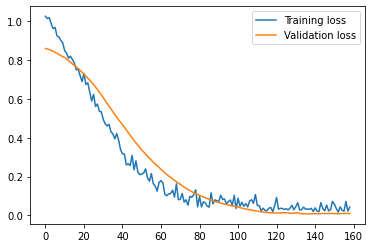

In [165]:
model_HUGE = build_model(trainX_PYCO, trainY_PYCO, 200, 16)

Index(['2019-12-01', '2020-04-01', '2020-02-01'], dtype='object', name='invoice_month')


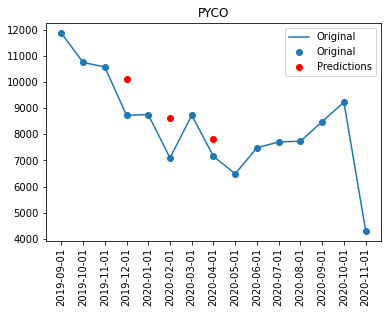

MSE: 1576754.521591992
MAE:  1194.1657116399174


In [166]:
custom_evaluate_predictions(model_HUGE, PYCO_custom)

Index(['2020-02-01', '2020-06-01', '2020-04-01'], dtype='object', name='invoice_month')


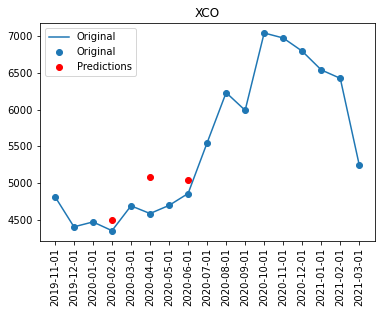

MSE: 102978.47811429425
MAE:  278.46030928553984


In [167]:
custom_evaluate_predictions(model_HUGE, XCO_custom)

Index(['2020-11-01'], dtype='object', name='invoice_month')


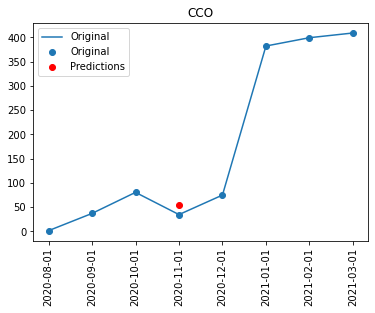

MSE: 411.83113143686126
MAE:  20.293622925364048


In [168]:
custom_evaluate_predictions(model_HUGE, CCO_custom)

In [ ]:
def to_supervised (df_for_training, n_future, n_past):
    trainX = []
    trainY = []

    for i in range(n_past, len(df_for_training) - n_future +1):
        trainX.append(df_for_training[i - n_past:i, 0:df_for_training.shape[1]])
        trainY.append(df_for_training[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    
    return trainX, trainY


In [ ]:
def future_tensor(df, n_past):
    timeframe = df.loc[:,-n_past:]
    


# Training : We tried ARIMA, Holt-Winters, and LSTM since the data was of Time Series form. We evaluated model performance with MSE, R^2, and visual examination.

In [ ]:
import 

In [ ]:
def tweak (model, data):
    
    ss= data.ss
    X = data.test_X.copy()
    
    
    metrics = evaluate_predictionsT(model, ss, X, y, "Original")
    mse = metrics["mse"].copy()
    
    df = pd.DataFrame(columns = ['Feature', 'MSE', 'MSE_dif', 'Importance'])
    df["Feature"] = ["Core_Outlet_Temperature", "Reactor_Power", "Tank_Level", "Heat_Exchanger_Outlet_Temperature" , "Heat_Exchanger_Outlet_Pressure",
                     "Reactor_Outlet_Pressure", "Cold_Leg_Velocity"]
    
    values = np.zeros(X.shape[0]*X.shape[1])
   
    # seed random number generator
    seed(1)
    for j in range (len(values)):
        values[j]= gauss(0, 1)
    values = np.reshape(values, (X[:,:,0].shape))
    
    for i in range (X.shape[2]):
        name = df.at[i, "Feature"]
        tweak = X.copy()
        tweak[:,:, i] = values
        t_metrics = evaluate_predictionsT(model, ss, tweak, y, name)
        nmse = t_metrics["mse"]
        df.at[i, "MSE"] = nmse
        df.at[i, "MSE_dif"] = nmse-mse
    
    df['Importance'] = 100*df['MSE_dif'] / df['MSE_dif'].max()
    plt.barh(df.Feature, df.Importance)

    return df